In [2]:
%%bash
for idx in 0 1 2 3 4 5; do
    bedfile="../coordinates/coordinates_"$idx".bed"
    cat $bedfile | perl -lane 'print $F[0]."\t".($F[1]+$F[9]-500)."\t".($F[1]+$F[9]+500)' > expanded_coordinates_$idx.bed
    bedtools getfasta -fi /mnt/data/annotations/by_release/hg19/male.hg19.fa -bed expanded_coordinates_$idx.bed > expanded_coordinates_$idx.fa
done

In [3]:
indices = [0,1,2,3,4,5]
fastafiles = ["expanded_coordinates_"+str(idx)+".fa" for idx in indices]
model_hdf5 = "DNASE.K562.regressionlabels.allbins.0"

In [4]:
!md5sum DNASE.K562.regressionlabels.allbins.0

f46d83d699aea9428efe1535731eb81b  DNASE.K562.regressionlabels.allbins.0


In [5]:
from keras.models import load_model
import tensorflow as tf
from keras import backend as K

def ambig_binary_crossentropy(y_true,y_pred):
    nonAmbig=tf.math.logical_not(tf.is_nan(y_true))
    return K.mean(K.binary_crossentropy(tf.boolean_mask(y_true,nonAmbig), tf.boolean_mask(y_pred,nonAmbig)), axis=-1);

def dummy_metric(y,z):
    return tf.reduce_mean(y)

loaded_model = load_model(model_hdf5,
                          custom_objects={
                            'ambig_mean_squared_error': ambig_binary_crossentropy,
                            'sensitivity': dummy_metric,
                            'specificity': dummy_metric,
                            'precision': dummy_metric,
                            'recall': dummy_metric,
                            'fpr': dummy_metric,
                            'fnr': dummy_metric,
                            'tnr': dummy_metric,
                            'f1': dummy_metric,
                            'tpr': dummy_metric})

W0709 17:17:23.896869 140616266041088 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 17:17:23.940327 140616266041088 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 17:17:23.980336 140616266041088 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 17:17:23.981257 140616266041088 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_defau

In [6]:
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

sequences_sets = [[x[1].rstrip() for x in enumerate(open(fastafile)) if x[0]%2==1]
                  for fastafile in fastafiles]
onehot_func = lambda x: np.array([one_hot_encode_along_channel_axis(seq)[None,:,:] for seq in x])
onehot_sets = [onehot_func(x).squeeze() for x in sequences_sets]

In [ ]:
%reload_ext autoreload
%autoreload 2
import locusselect
import importlib
from locusselect.ism import in_silico_mutagenesis

for idx,(sequences,onehot) in list(enumerate(zip(sequences_sets, onehot_sets)))[1:]:
    onehot = onehot[:,None,:,:]
    ism_scores = in_silico_mutagenesis(model=loaded_model,
                                       X=onehot, task_index=0, target_layer_idx=-1,
                                       start_pos=375, end_pos=625)
    ism_scores = np.squeeze(ism_scores)
    np.save("ismscores_"+str(idx)+".npy", ism_scores)

ISM: task:0 sample:0
ISM: task:0 sample:1
ISM: task:0 sample:2
ISM: task:0 sample:3
ISM: task:0 sample:4
ISM: task:0 sample:5
ISM: task:0 sample:6
ISM: task:0 sample:7
ISM: task:0 sample:8
ISM: task:0 sample:9
ISM: task:0 sample:10
ISM: task:0 sample:11
ISM: task:0 sample:12
ISM: task:0 sample:13
ISM: task:0 sample:14
ISM: task:0 sample:15
ISM: task:0 sample:16
ISM: task:0 sample:17
ISM: task:0 sample:18
ISM: task:0 sample:19
ISM: task:0 sample:20
ISM: task:0 sample:21
ISM: task:0 sample:22
ISM: task:0 sample:23
ISM: task:0 sample:24
ISM: task:0 sample:25
ISM: task:0 sample:26
ISM: task:0 sample:27
ISM: task:0 sample:28
ISM: task:0 sample:29
ISM: task:0 sample:30
ISM: task:0 sample:31
ISM: task:0 sample:32
ISM: task:0 sample:33
ISM: task:0 sample:34
ISM: task:0 sample:35
ISM: task:0 sample:36
ISM: task:0 sample:37
ISM: task:0 sample:38
ISM: task:0 sample:39
ISM: task:0 sample:40
ISM: task:0 sample:41
ISM: task:0 sample:42
ISM: task:0 sample:43
ISM: task:0 sample:44
ISM: task:0 sample:4

ISM: task:0 sample:361
ISM: task:0 sample:362
ISM: task:0 sample:363
ISM: task:0 sample:364
ISM: task:0 sample:365
ISM: task:0 sample:366
ISM: task:0 sample:367
ISM: task:0 sample:368
ISM: task:0 sample:369
ISM: task:0 sample:370
ISM: task:0 sample:371
ISM: task:0 sample:372
ISM: task:0 sample:373
ISM: task:0 sample:374
ISM: task:0 sample:375
ISM: task:0 sample:376
ISM: task:0 sample:377
ISM: task:0 sample:378
ISM: task:0 sample:379
ISM: task:0 sample:380
ISM: task:0 sample:381
ISM: task:0 sample:382
ISM: task:0 sample:383
ISM: task:0 sample:384
ISM: task:0 sample:385
ISM: task:0 sample:386
ISM: task:0 sample:387
ISM: task:0 sample:388
ISM: task:0 sample:389
ISM: task:0 sample:390
ISM: task:0 sample:391
ISM: task:0 sample:392
ISM: task:0 sample:393
ISM: task:0 sample:394
ISM: task:0 sample:395
ISM: task:0 sample:396
ISM: task:0 sample:397
ISM: task:0 sample:398
ISM: task:0 sample:399
ISM: task:0 sample:400
ISM: task:0 sample:401
ISM: task:0 sample:402
ISM: task:0 sample:403
ISM: task:0

ISM: task:0 sample:718
ISM: task:0 sample:719
ISM: task:0 sample:720
ISM: task:0 sample:721
ISM: task:0 sample:722
ISM: task:0 sample:723
ISM: task:0 sample:724
ISM: task:0 sample:725
ISM: task:0 sample:726
ISM: task:0 sample:727
ISM: task:0 sample:728
ISM: task:0 sample:729
ISM: task:0 sample:730
ISM: task:0 sample:731
ISM: task:0 sample:732
ISM: task:0 sample:733
ISM: task:0 sample:734
ISM: task:0 sample:735
ISM: task:0 sample:736
ISM: task:0 sample:737
ISM: task:0 sample:738
ISM: task:0 sample:739
ISM: task:0 sample:740
ISM: task:0 sample:741
ISM: task:0 sample:742
ISM: task:0 sample:743
ISM: task:0 sample:744
ISM: task:0 sample:745
ISM: task:0 sample:746
ISM: task:0 sample:747
ISM: task:0 sample:748
ISM: task:0 sample:749
ISM: task:0 sample:750
ISM: task:0 sample:751
ISM: task:0 sample:752
ISM: task:0 sample:753
ISM: task:0 sample:754
ISM: task:0 sample:755
ISM: task:0 sample:756
ISM: task:0 sample:757
ISM: task:0 sample:758
ISM: task:0 sample:759
ISM: task:0 sample:760
ISM: task:0

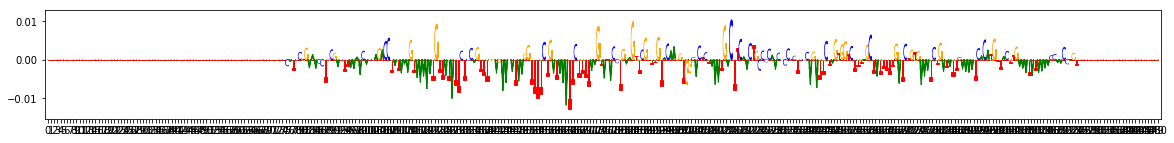

In [14]:
%matplotlib inline

from deeplift.visualization import viz_sequence
viz_sequence.plot_weights(ism_scores[0][300:650]*onehot[0,0][300:650])


In [9]:
import deeplift
from deeplift.conversion import kerasapi_conversion as kc

grad_model =\
    kc.convert_model_from_saved_files(
        model_hdf5,
        nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.Gradient)
grad_contribs_func = grad_model.get_target_contribs_func(
                            find_scores_layer_idx=0,
                            target_layer_idx=-1)

nonlinear_mxts_mode is set to: Gradient


W0709 16:24:35.623578 140647987721984 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/deeplift/layers/pooling.py:296: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)


In [13]:
for idx,(sequences,onehot) in enumerate(zip(sequences_sets, onehot_sets)):
    onehot = onehot[:,None,:,:]
    gradtimesinp_scores = np.array(grad_contribs_func(
        task_idx=0,
        input_data_list=[onehot],
        batch_size=200,
        progress_update=1000))
    print(gradtimesinp_scores.shape)
    onehot = np.squeeze(onehot)
    gradtimesinp_scores = np.squeeze(gradtimesinp_scores)
    np.save("grad_scores_"+str(idx)+".npy", gradtimesinp_scores)

No reference provided - using zeros
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
(8001, 1, 1000, 4)
No reference provided - using zeros
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
(4652, 1, 1000, 4)
No reference provided - using zeros
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
(8001, 1, 1000, 4)
No reference provided - using zeros
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
(8001, 1, 1000, 4)
No reference provided - using zeros
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
(8001, 1, 1000, 4)
No reference provided - using zeros
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
(8001, 1, 1000, 4)


In [14]:
import deeplift
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import get_shuffle_seq_ref_function
from deeplift.dinuc_shuffle import dinuc_shuffle

deeplift_model =\
    kc.convert_model_from_saved_files(
        model_hdf5,
        nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.Rescale)
deeplift_contribs_func = deeplift_model.get_target_contribs_func(
                            find_scores_layer_idx=0,
                            target_layer_idx=-1)
scoring_func = get_shuffle_seq_ref_function(
    #score_computation_function is the original function to compute scores
    score_computation_function=deeplift_contribs_func,
    #shuffle_func is the function that shuffles the sequence
    #technically, given the background of this simulation, randomly_shuffle_seq
    #makes more sense. However, on real data, a dinuc shuffle is advisable due to
    #the strong bias against CG dinucleotides
    shuffle_func=dinuc_shuffle,
    one_hot_func=None)

nonlinear_mxts_mode is set to: Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)


In [15]:
for idx,sequences in enumerate(sequences_sets):
    onehot = onehot_func(sequences)
    deeplift_scores = scoring_func(
        task_idx=0,
        input_data_sequences=onehot,
        num_refs_per_seq=10,
        batch_size=200,
        progress_update=1000)
    print(deeplift_scores.shape)
    onehot = np.squeeze(onehot)
    deeplift_scores = np.squeeze(deeplift_scores)
    projected_deeplift = np.sum(deeplift_scores, axis=-1)[:,:,None]*onehot
    print(projected_deeplift.shape)
    np.save("deeplift_scores_"+str(idx)+".npy", projected_deeplift)

1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs generated
4000 reference seqs generated
5000 reference seqs generated
6000 reference seqs generated
7000 reference seqs generated
8000 reference seqs generated
9000 reference seqs generated
10000 reference seqs generated
11000 reference seqs generated
12000 reference seqs generated
13000 reference seqs generated
14000 reference seqs generated
15000 reference seqs generated
16000 reference seqs generated
17000 reference seqs generated
18000 reference seqs generated
19000 reference seqs generated
20000 reference seqs generated
21000 reference seqs generated
22000 reference seqs generated
23000 reference seqs generated
24000 reference seqs generated
25000 reference seqs generated
26000 reference seqs generated
27000 reference seqs generated
28000 reference seqs generated
29000 reference seqs generated
30000 reference seqs generated
31000 reference seqs generated
32000 reference seqs generated
33000 reference s

Done 36000
Done 37000
Done 38000
Done 39000
Done 40000
Done 41000
Done 42000
Done 43000
Done 44000
Done 45000
Done 46000
Done 47000
Done 48000
Done 49000
Done 50000
Done 51000
Done 52000
Done 53000
Done 54000
Done 55000
Done 56000
Done 57000
Done 58000
Done 59000
Done 60000
Done 61000
Done 62000
Done 63000
Done 64000
Done 65000
Done 66000
Done 67000
Done 68000
Done 69000
Done 70000
Done 71000
Done 72000
Done 73000
Done 74000
Done 75000
Done 76000
Done 77000
Done 78000
Done 79000
Done 80000
(8001, 1, 1000, 4)
(8001, 1000, 4)
1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs generated
4000 reference seqs generated
5000 reference seqs generated
6000 reference seqs generated
7000 reference seqs generated
8000 reference seqs generated
9000 reference seqs generated
10000 reference seqs generated
11000 reference seqs generated
12000 reference seqs generated
13000 reference seqs generated
14000 reference seqs generated
15000 reference seqs generated
16000 referenc

KeyboardInterrupt: 

In [55]:
def make_altered_inputs_for_ism(original_onehot):
    altered_inputs = []
    altered_input_posandbase = []
    for pos_idx in range(375,625):
        for base_idx in range(4):
            new_inp = np.array(original_onehot)
            new_inp[pos_idx] = 0.0
            new_inp[pos_idx][base_idx] = 1.0
            altered_inputs.append(new_inp)
            altered_input_posandbase.append((pos_idx, base_idx))
    return altered_inputs, altered_input_posandbase
def do_ism(onehots, prediction_func, make_altered_inputs_func):
    for onehot in onehots:
        altered_inputs, an